<a href="https://colab.research.google.com/github/run-llama/llama_parse/blob/main/examples/excel/o1_excel_rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced RAG with LlamaParse + OpenAI O1 on Excel

This notebook provides a reference to compare advanced RAG capabilities using LlamaParse and Recursive Retrieval with `o1-preview`, `o1-mini` and `gpt4o-mini` on a sample Excel document.

We will use the [`2Q 2024 Group databook - xls`](https://www.bp.com/content/dam/bp/business-sites/en/global/corporate/xlsx/investors/bp-second-quarter-2024-results-group-databook.xlsx) file from [bp.com](https://www.bp.com/en/global/corporate/investors/results-reporting-and-presentations/financial-disclosure-framework/archive.html) for our demonstration.

When interacting with our enterprise customers, we've identified two prominent types of queries. Let's check how they perform with the o1 models:

1. Queries requesting exact values.
2. Queries using the greater than/less than (>/ <) operators.

#### Installation

In [ ]:
# !pip install llama-index
# !pip install llama-parse

## Imports

In [1]:
import nest_asyncio

from llama_index.llms.openai import OpenAI
from llama_index.core import VectorStoreIndex
from IPython.display import Image, Markdown

from llama_parse import LlamaParse

from llama_index.core.node_parser import MarkdownElementNodeParser

In [2]:
# llama-parse is async-first, running the async code in a notebook requires the use of nest_asyncio
nest_asyncio.apply()

#### Setup LLM

In [ ]:
import os

os.environ["OPENAI_API_KEY"] = "sk-..."

llm_o1 = OpenAI(model="o1-mini")
llm_gpt4o_mini = OpenAI(model="gpt-4o-mini")
llm_o1_preview = OpenAI(model="o1-preview")

## Using `LlamaParse` with Recursive Retrieval

LlamaParse is our document parser that can parse a variety of document types, including Excel files, into well-formatted outputs.

We rely on LlamaParse to parse this Excel sheet into structured markdown.

We then use the `MarkdownElementNodeParser` to parse the `LlamaParse` output Markdown results and build a hierarchical index over this data for recursive retrieval. See below for a diagram of how this works.

1. We extract a summary from each sheet and index that.
2. During synthesis we feed the source sheet back into the LLM as context to synthesize the answer.

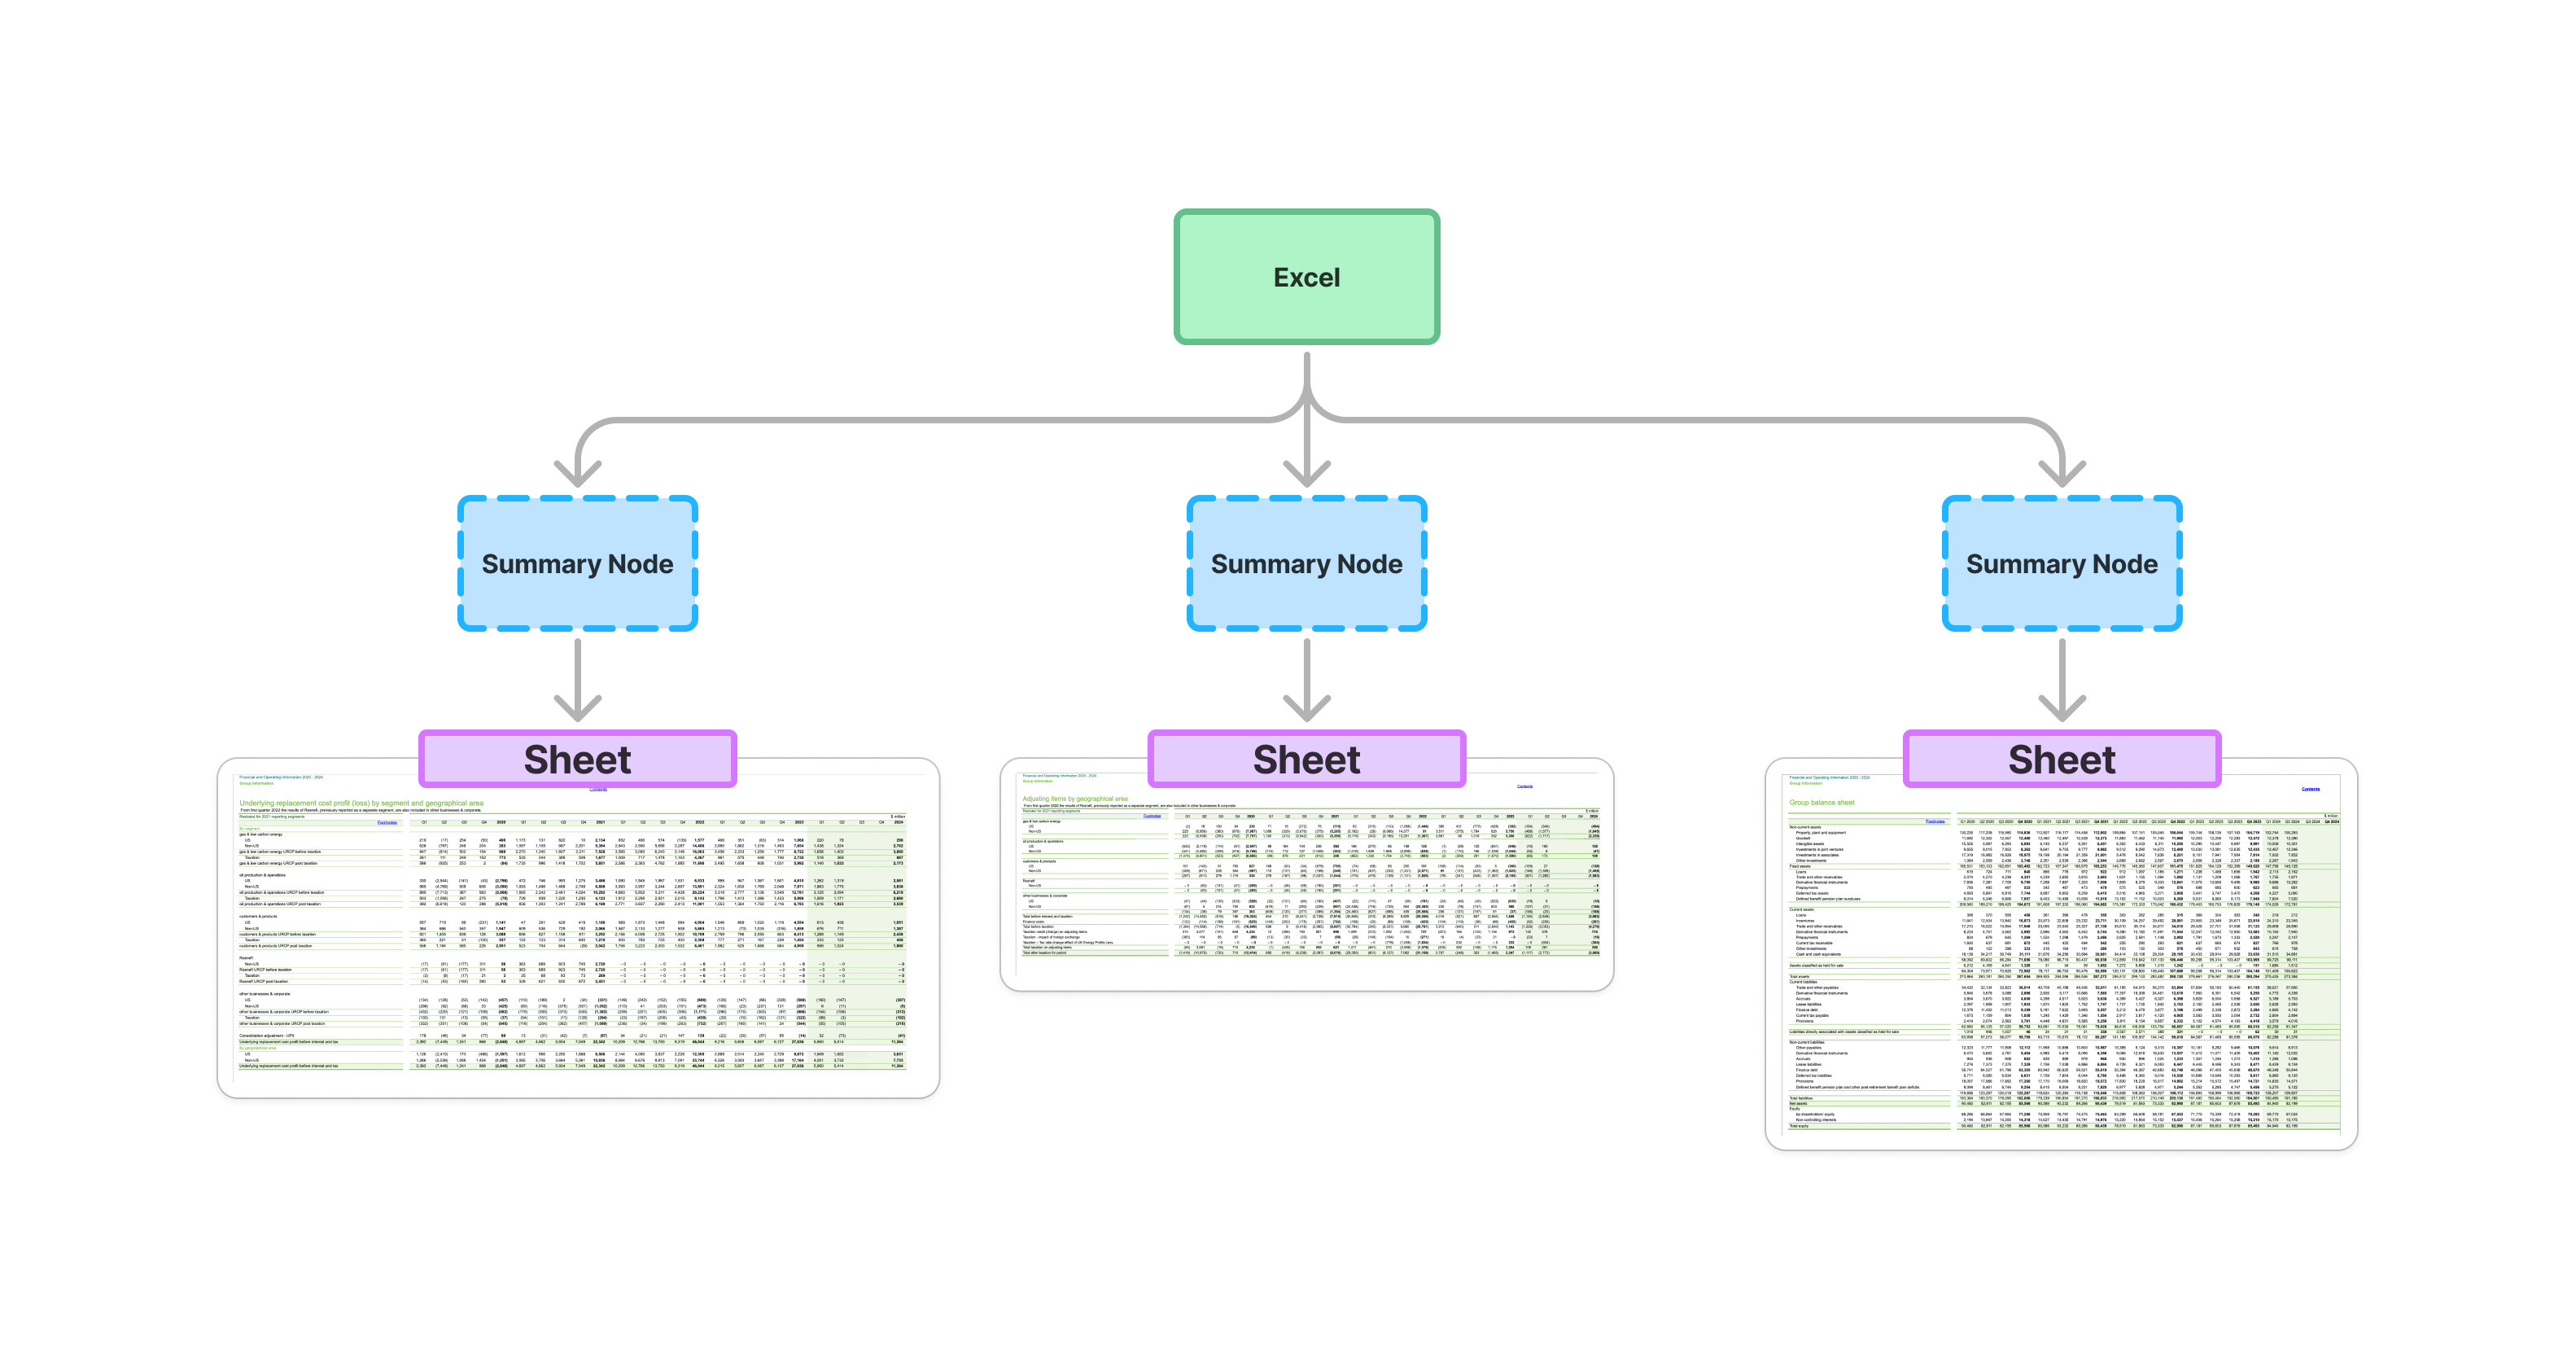

In [4]:
# Recursive Retrieval

Image(filename="./references/recursive_retrieval.png")

#### LlamaParse

In [ ]:
parser = LlamaParse(
    api_key="llx-...",
    result_type="markdown",
)

documents = parser.load_data("../data/BP_Excel.xlsx")

Started parsing the file under job_id 440b7077-1f9e-4273-a32d-7e281cb76095


In [ ]:
len(documents)

44

In [ ]:
print(documents[3].get_content())

# Summary

|Financial and Operating Information 2020 - 2024                          |           |        |        |        |        |        |        |        |        |        |        |         |        |        |        |        |        |        |        |        |        |        |        |      |      |           |
|-------------------------------------------------------------------------|-----------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|---------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|------|------|-----------|
|Group information                                                        |           |        |        |        |        |        |        |        |        |        |        |         |        |        |        |        |        |        |        |        |        |        |        |      |      |           |
|                                                 

#### MarkdownElementNodeParser

This will generate a summary for each node; if a table is present, it will also create a summary for the table.

In [ ]:
node_parser = MarkdownElementNodeParser(llm=llm_gpt4o_mini, num_workers=4)

### Parse the documents

In [ ]:
nodes = node_parser.get_nodes_from_documents(documents[:10])

1it [00:00, 1563.29it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
1it [00:00, 3761.71it/s]
1it [00:00, 1265.25it/s]
1it [00:00, 4624.37it/s]
1it [00:00, 2713.00it/s]
1it [00:00, 3994.58it/s]
1it [00:00, 3711.77it/s]
1it [00:00, 2788.77it/s]


In [ ]:
base_nodes, objects = node_parser.get_nodes_and_objects(nodes)

In [ ]:
len(nodes), len(base_nodes), len(objects)

(27, 11, 8)

In [ ]:
print(objects[3].get_content())

This table presents the financial and operating information of a group from 2020 to 2024, detailing the condensed statement of comprehensive income, including profit or loss for the period, other comprehensive income items, and total comprehensive income attributable to shareholders and non-controlling interests.,
with the following table title:
Financial and Operating Information 2020 - 2024,
with the following columns:
- Group information: None
- Condensed group statement of comprehensive income: None
- Profit (loss) for the period: None
- Other comprehensive income: None
- Total comprehensive income: None
- Attributable to bp shareholders: None
- Attributable to non-controlling interests: None



#### Build Recursive Retrieval Index

In [ ]:
# dump both indexed tables and page text into the vector index
recursive_index = VectorStoreIndex(nodes=base_nodes + objects, llm=llm_gpt4o_mini)

recursive_query_engine_o1 = recursive_index.as_query_engine(
    similarity_top_k=5, llm=llm_o1
)

recursive_query_engine_o1_preview = recursive_index.as_query_engine(
    similarity_top_k=5, llm=llm_o1_preview
)

recursive_query_engine_gpt4o_mini = recursive_index.as_query_engine(
    similarity_top_k=5, llm=llm_gpt4o_mini
)

# Testing queries

### <font color="#2244FF">Query 1</font>

Expected Answer:

$105,944 Million

Sheet Reference: Group Income Statement.

In [ ]:
query = "What is the Sales and other operating revenues in 2020?"

response_recursive_o1 = recursive_query_engine_o1.query(query)
response_recursive_o1_preview = recursive_query_engine_o1_preview.query(query)
response_recursive_gpt4o_mini = recursive_query_engine_gpt4o_mini.query(query)

In [ ]:
print("----------------------RESPONSE WITH O1 MINI----------------------")
display(Markdown(f"{response_recursive_o1}"))

print("----------------------RESPONSE WITH O1 PREVIEW----------------------")
display(Markdown(f"{response_recursive_o1_preview}"))

print("----------------------RESPONSE WITH GPT4O-MINI----------------------")
display(Markdown(f"{response_recursive_gpt4o_mini}"))

----------------------RESPONSE WITH O1 MINI----------------------


In 2020, the Sales and other operating revenues were $105,944 million.

----------------------RESPONSE WITH O1 PREVIEW----------------------


The Sales and other operating revenues in 2020 were $105,944 million.

----------------------RESPONSE WITH GPT4O-MINI----------------------


The Sales and other operating revenues in 2020 amount to 105,944 million dollars.

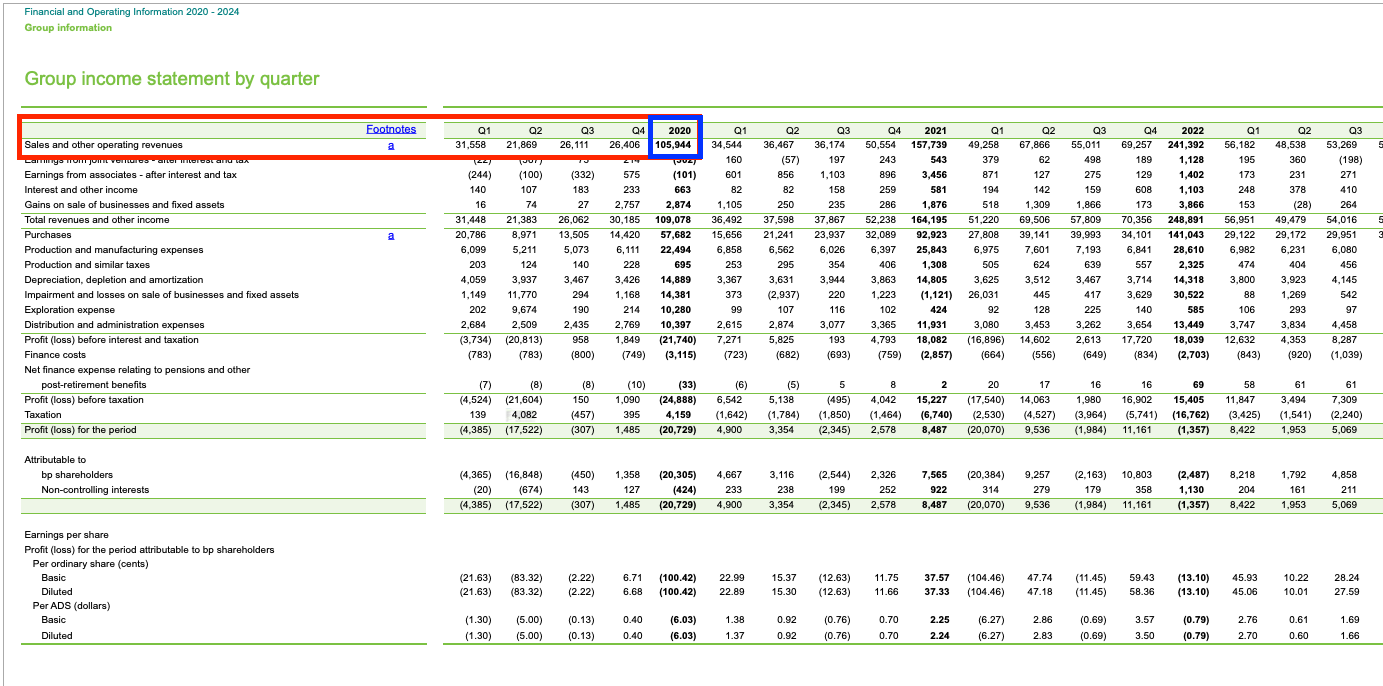

In [ ]:
# Reference page for query and answer

Image(filename="./references/query1.png")

Source node from which answer is generated.

In [ ]:
print(response_recursive_o1.source_nodes[0].get_content())

This table presents the financial and operating information of a group from 2020 to 2024, detailing gains and losses from various activities, including sales of businesses, impairments, provisions, and restructuring costs across different segments such as gas, oil production, and other businesses.,
with the following table title:
Financial and Operating Information 2020 - 2024,
with the following columns:
- Group information: None
- Adjusting items: None
- gas & low carbon energy: None
- oil production & operations: None
- customers & products: None
- Rosneft: None
- other businesses & corporate: None
- Total before interest and taxation: None
- Finance costs: None
- Total before taxation: None
- Total after taxation for period: None

|Financial and Operating Information 2020 - 2024                                                                    |                                                            |         |       |        |      |       .1|        .1|       .2|       .3|  

### <font color="#2244FF">Query 2</font>

Expected Answer:

2021, 2022, 2023

Sheet Reference: Group Income Statement.

In [ ]:
query = "In which years the Sales and other operating revenues is greater than $1,50,000 million?"

response_recursive_o1 = recursive_query_engine_o1.query(query)
response_recursive_o1_preview = recursive_query_engine_o1_preview.query(query)
response_recursive_gpt4o_mini = recursive_query_engine_gpt4o_mini.query(query)

In [ ]:
print("----------------------RESPONSE WITH O1 MINI----------------------")
display(Markdown(f"{response_recursive_o1}"))

print("----------------------RESPONSE WITH O1 PREVIEW----------------------")
display(Markdown(f"{response_recursive_o1_preview}"))

print("----------------------RESPONSE WITH GPT4O-MINI----------------------")
display(Markdown(f"{response_recursive_gpt4o_mini}"))

----------------------RESPONSE WITH O1 MINI----------------------


Sales and other operating revenues exceeded $150,000 million in the years 2021, 2022, and 2023.

----------------------RESPONSE WITH O1 PREVIEW----------------------


The Sales and other operating revenues exceeded $150,000 million in the years 2021, 2022, and 2023.

----------------------RESPONSE WITH GPT4O-MINI----------------------


The Sales and other operating revenues exceed $150,000 million in the years 2021 and 2022.

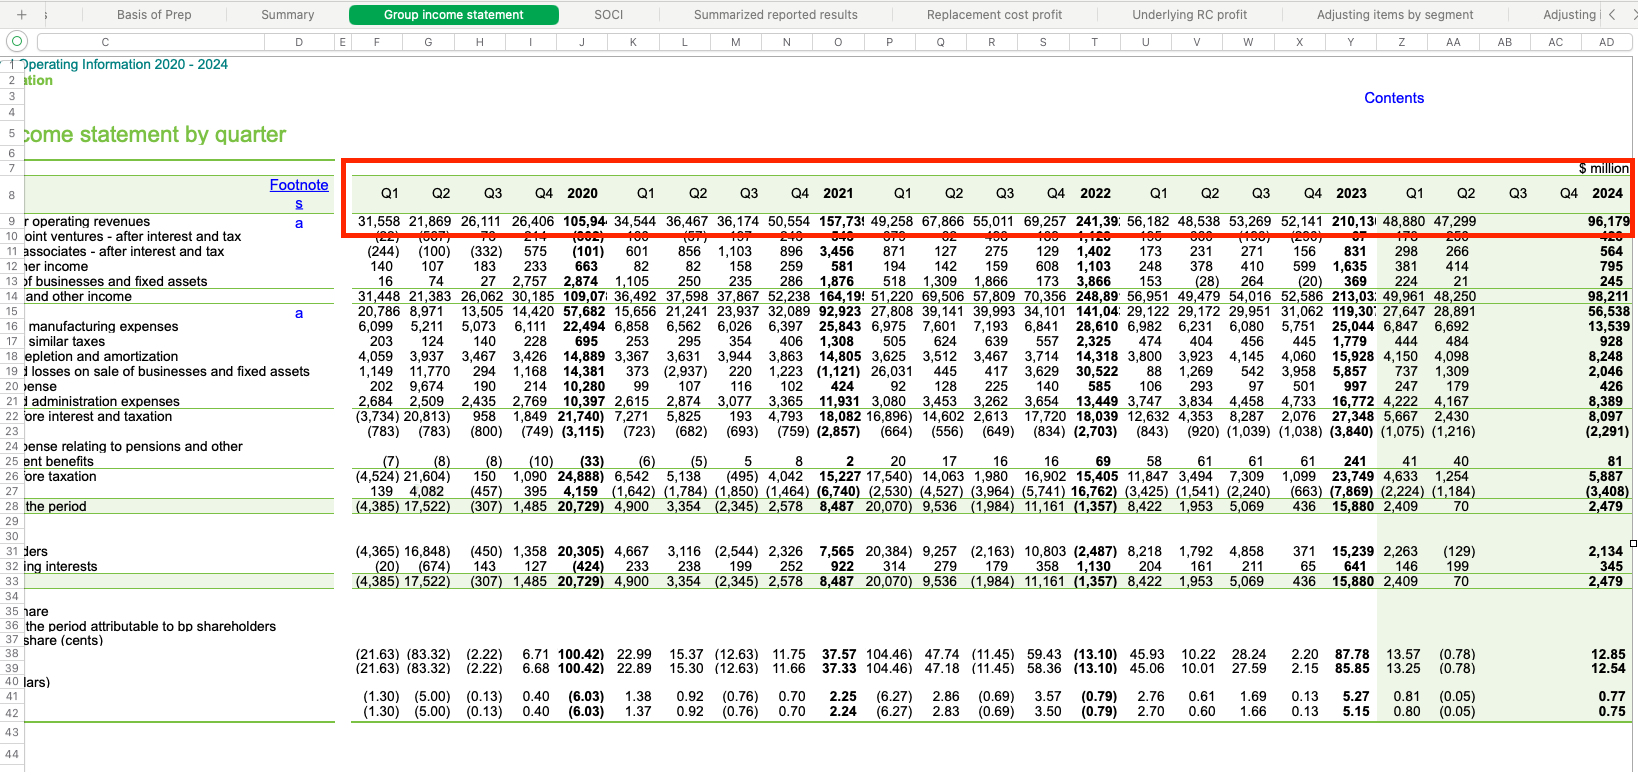

In [ ]:
# Reference page for query and answer

Image(filename="./references/query2.png")

Source node from which answer is generated.

In [ ]:
print(response_recursive_o1.source_nodes[1].get_content())

This table presents the financial and operating information of a group from 2020 to 2024, detailing quarterly income statements, revenues, expenses, and profit/loss figures.,
with the following table title:
Financial and Operating Information 2020 - 2024,
with the following columns:
- Group information: None
- Group income statement by quarter: None
- Sales and other operating revenues: None
- Earnings from joint ventures - after interest and tax: None
- Earnings from associates - after interest and tax: None
- Interest and other income: None
- Gains on sale of businesses and fixed assets: None
- Total revenues and other income: None
- Purchases: None
- Production and manufacturing expenses: None
- Production and similar taxes: None
- Depreciation, depletion and amortization: None
- Impairment and losses on sale of businesses and fixed assets: None
- Exploration expense: None
- Distribution and administration expenses: None
- Profit (loss) before interest and taxation: None
- Finance c

### <font color="#2244FF">Query 3</font>

Expected Answer:

2021: Q1, Q2, Q3, Q4

2022: Q1, Q2, Q3, Q4

2023: Q1, Q2


Sheet Reference: Group Income Statement.

In [ ]:
query = "Which quarters and years has Total revenues and other income greater than $35K million?"

response_recursive_o1 = recursive_query_engine_o1.query(query)
response_recursive_o1_preview = recursive_query_engine_o1_preview.query(query)
response_recursive_gpt4o_mini = recursive_query_engine_gpt4o_mini.query(query)

In [ ]:
print("----------------------RESPONSE WITH O1 MINI----------------------")
display(Markdown(f"{response_recursive_o1}"))

print("----------------------RESPONSE WITH O1 PREVIEW----------------------")
display(Markdown(f"{response_recursive_o1_preview}"))

print("----------------------RESPONSE WITH GPT4O-MINI----------------------")
display(Markdown(f"{response_recursive_gpt4o_mini}"))

----------------------RESPONSE WITH O1 MINI----------------------


Total revenues and other income exceeded $35,000 million in the following quarters and years:

- **2021:** Q1, Q2, Q3, Q4
- **2022:** Q1, Q2, Q3, Q4
- **2023:** Q1, Q2, Q3, Q4
- **2024:** Q1, Q2

----------------------RESPONSE WITH O1 PREVIEW----------------------


The quarters and years in which Total revenues and other income exceeded $35,000 million are:

- **2021**: All quarters—Q1, Q2, Q3, and Q4.
- **2022**: All quarters—Q1, Q2, Q3, and Q4.
- **2023**: All quarters—Q1, Q2, Q3, and Q4.
- **2024**: The first two quarters—Q1 and Q2.

Additionally, none of the quarters in **2020** had Total revenues and other income exceeding $35,000 million.

----------------------RESPONSE WITH GPT4O-MINI----------------------


The quarters and years where Total revenues and other income exceeded $35,000 million are:

- Q1 2021: $36,492 million
- Q2 2021: $37,598 million
- Q3 2021: $37,867 million
- Q4 2021: $52,238 million
- Q1 2022: $51,220 million
- Q2 2022: $69,506 million
- Q3 2022: $57,809 million
- Q4 2022: $70,356 million
- Q1 2023: $56,951 million
- Q2 2023: $49,479 million
- Q3 2023: $54,016 million
- Q4 2023: $52,586 million
- Q1 2024: $49,961 million
- Q2 2024: $48,250 million

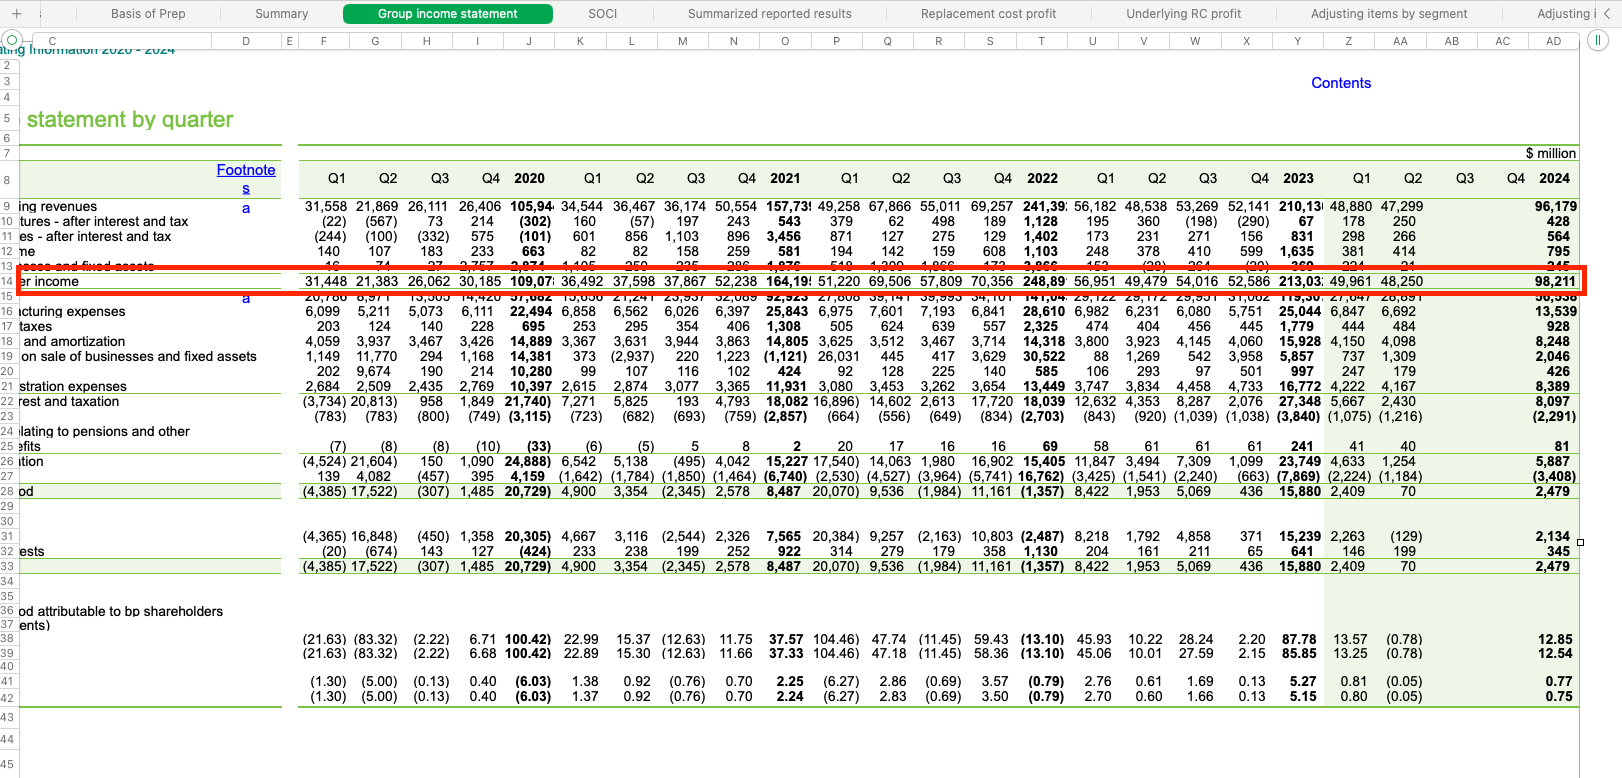

In [ ]:
# Reference page for query and answer

Image(filename="./references/query3.png")

Source node from which answer is generated.

In [ ]:
print(response_recursive_o1.source_nodes[2].get_content())

This table presents the financial and operating information of a group from 2020 to 2024, detailing quarterly income statements, revenues, expenses, and profit/loss figures.,
with the following table title:
Financial and Operating Information 2020 - 2024,
with the following columns:
- Group information: None
- Group income statement by quarter: None
- Sales and other operating revenues: None
- Earnings from joint ventures - after interest and tax: None
- Earnings from associates - after interest and tax: None
- Interest and other income: None
- Gains on sale of businesses and fixed assets: None
- Total revenues and other income: None
- Purchases: None
- Production and manufacturing expenses: None
- Production and similar taxes: None
- Depreciation, depletion and amortization: None
- Impairment and losses on sale of businesses and fixed assets: None
- Exploration expense: None
- Distribution and administration expenses: None
- Profit (loss) before interest and taxation: None
- Finance c

### <font color="#2244FF">Query 4</font>

Expected Answer:

Q1

Sheet Reference: SOCI

In [ ]:
query = (
    "Which quarters in 2023 is Total comprehensive income greater than $9000 million?"
)

response_recursive_o1 = recursive_query_engine_o1.query(query)
response_recursive_o1_preview = recursive_query_engine_o1_preview.query(query)
response_recursive_gpt4o_mini = recursive_query_engine_gpt4o_mini.query(query)

In [ ]:
print("----------------------RESPONSE WITH O1 MINI----------------------")
display(Markdown(f"{response_recursive_o1}"))

print("----------------------RESPONSE WITH O1 PREVIEW----------------------")
display(Markdown(f"{response_recursive_o1_preview}"))

print("----------------------RESPONSE WITH GPT4O-MINI----------------------")
display(Markdown(f"{response_recursive_gpt4o_mini}"))

----------------------RESPONSE WITH O1 MINI----------------------


In 2023, the total comprehensive income exceeded $9,000 million in the second and fourth quarters.

----------------------RESPONSE WITH O1 PREVIEW----------------------


In 2023, the Total comprehensive income exceeded $9,000 million in the first quarter (Q1) only.

----------------------RESPONSE WITH GPT4O-MINI----------------------


In 2023, the quarters where Total comprehensive income is greater than $9000 million are Q1 and Q4.

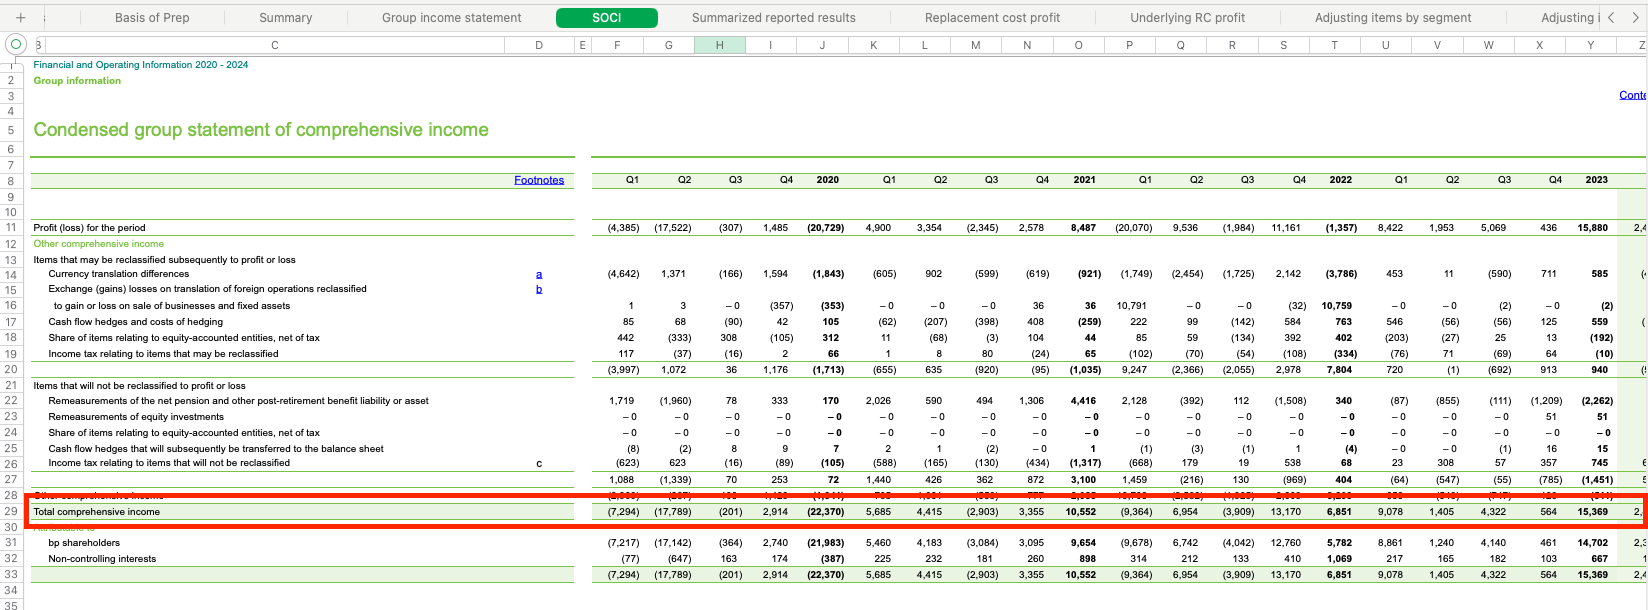

In [ ]:
# Reference page for query and answer

Image(filename="./references/query4.png")

Source node from which answer is generated.

In [ ]:
print(response_recursive_o1.source_nodes[1].get_content())

This table presents the financial and operating information of a group from 2020 to 2024, detailing the condensed statement of comprehensive income, including profit or loss for the period, other comprehensive income items, and total comprehensive income attributable to shareholders and non-controlling interests.,
with the following table title:
Financial and Operating Information 2020 - 2024,
with the following columns:
- Group information: None
- Condensed group statement of comprehensive income: None
- Profit (loss) for the period: None
- Other comprehensive income: None
- Total comprehensive income: None
- Attributable to bp shareholders: None
- Attributable to non-controlling interests: None

|Financial and Operating Information 2020 - 2024              |                                                                                      |         |       |        |     |       .1|        .1|       .2|       .3|       .4|       .5|        .2|        .3|       .6|       .7|       

### <font color="#2244FF">Query 5</font>

Expected Answer:

$392 million

Sheet Reference: Underlying RC Profit.

In [ ]:
query = "what is the replacement cost profit (loss) in oil production & operations URCP post taxation in Q1 of 2020?"

response_recursive_o1 = recursive_query_engine_o1.query(query)
response_recursive_o1_preview = recursive_query_engine_o1_preview.query(query)
response_recursive_gpt4o_mini = recursive_query_engine_gpt4o_mini.query(query)

In [ ]:
print("----------------------RESPONSE WITH O1 MINI----------------------")
display(Markdown(f"{response_recursive_o1}"))

print("----------------------RESPONSE WITH O1 PREVIEW----------------------")
display(Markdown(f"{response_recursive_o1_preview}"))

print("----------------------RESPONSE WITH GPT4O-MINI----------------------")
display(Markdown(f"{response_recursive_gpt4o_mini}"))

----------------------RESPONSE WITH O1 MINI----------------------


In the first quarter of 2020, the replacement cost profit (loss) for oil production and operations URCP was $392 million.

----------------------RESPONSE WITH O1 PREVIEW----------------------


In the first quarter of 2020, the replacement cost profit in oil production and operations URCP post taxation was 392 million dollars.

----------------------RESPONSE WITH GPT4O-MINI----------------------


The replacement cost profit (loss) in oil production & operations URCP post taxation in Q1 of 2020 is 392.

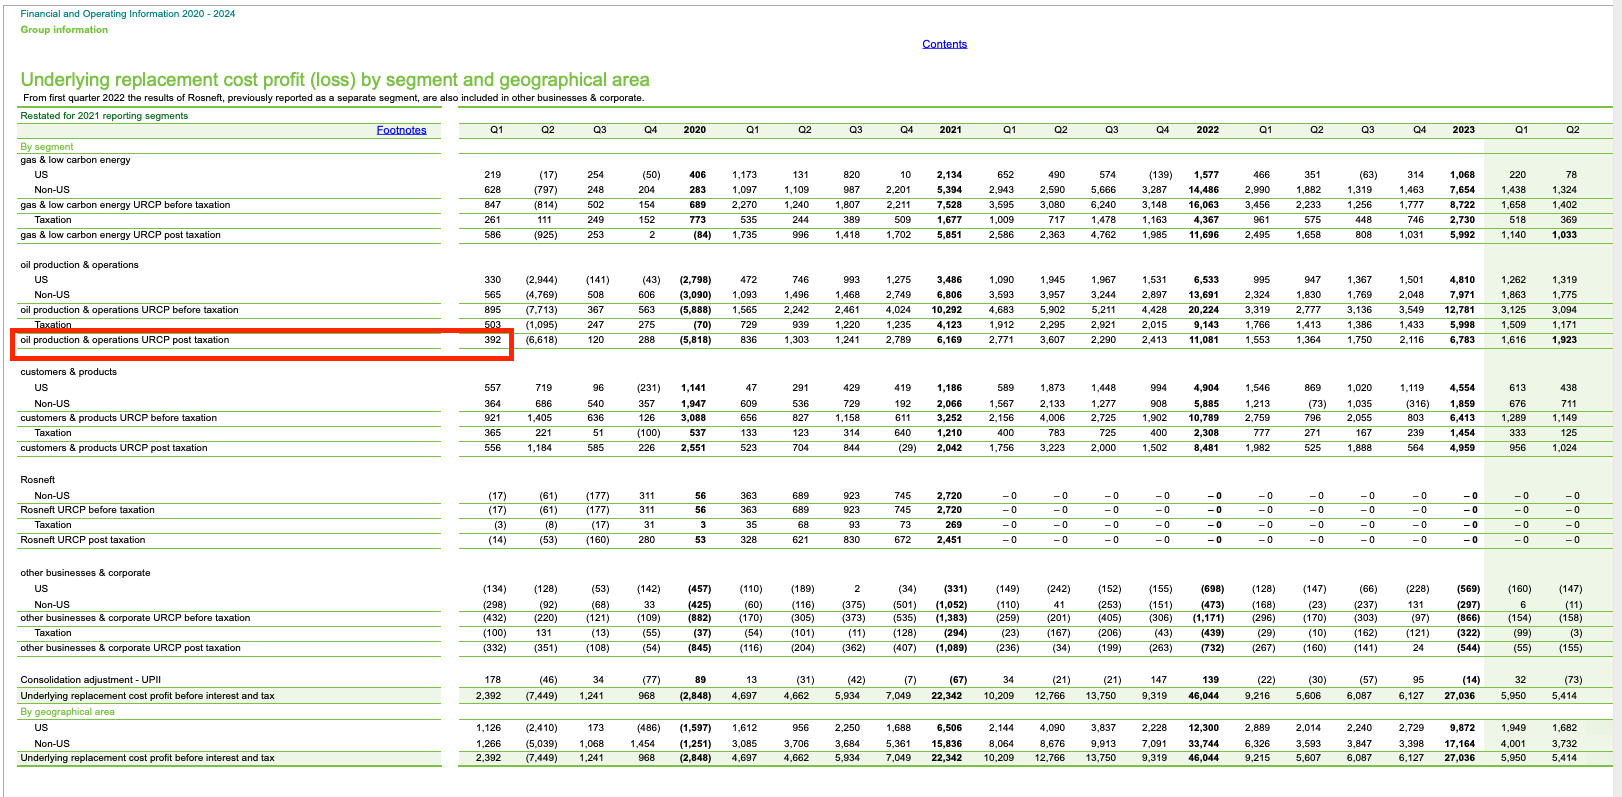

In [ ]:
# Reference page for query and answer

Image(filename="./references/query5.png")

Source node from which answer is generated.

In [ ]:
print(response_recursive_o1.source_nodes[3].get_content())

This table presents the financial and operating information of a group from 2020 to 2024, detailing underlying replacement cost profit (loss) by segment and geographical area, including specific data for gas & low carbon energy, oil production & operations, customers & products, and other businesses & corporate, along with taxation impacts.,
with the following table title:
Financial and Operating Information 2020 - 2024,
with the following columns:
- Group information: None
- Underlying replacement cost profit (loss) by segment and geographical area: None
- By segment: None
- By geographical area: None

|Financial and Operating Information 2020 - 2024                                                                                               |        |         |       |       .1|       .2|       .3|       .4|       .5|       .6|       .7|       .8|        .1|        .2|        .3|        .4|       .9|        .5|       .10|       .11|       .12|       .13|        .6|       .14|       

## Observation:

Although for some queries `o1-mini` and `o1-preview` outperformed GPT-4o-mini, `o1-preview` encountered issues with Query-4.

Careful evaluation is necessary when considering the use of o1-models for Excel RAG.